## Create and test ion channel model

In [1]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/nygren_Na.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv_Nao2,
                                                sakakibara_iv_Nao5,
                                                sakakibara_iv_Nao20,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1)

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact_kin_1)

In [5]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [6]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limits = {'ina.s1' : (0,1),
          
          'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (80,120),
          'ina.q2': (-20,20),
          'ina.r1': (25,75),
          'ina.r2': (-25,25),
          'ina.q3': (0,20),
          'ina.q4': (20,80),
          'ina.q5': (-25,25),
          'ina.q6': (0,20),
          'ina.q7': (0,20),
          'ina.q8': (0,20),
          'ina.r3': (0,1),
          'ina.r4': (0,100),
          'ina.r5': (0,100),
          'ina.r6': (0,0.01)}
"""
limits = {'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (0,100),
          'ina.q2': (0,100),
          'ina.r1': (0,100),
          'ina.r2': (-50,50)}
"""
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [7]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_ina_testing.db"))

In [8]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [9]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 65536 particles


In [10]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.4020598114534524, '1': 0.7915552537989841, '2': 1.1012942661551088, '3': 1.5390634418597822, '4': 1.5390634418597822, '5': 0.2825715176657425, '6': 0.805328825347366, '7': 1.5390634418597822}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=0.5, quantile_multiplier=1


In [11]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [12]:
#abc.load(db_path,56)

56

In [12]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=56, start_time=2019-08-20 17:13:56.114134, end_time=None)>


In [15]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5, min_acceptance_rate=0.005)

INFO:ABC:t:20 eps:0.28976187084825855
DEBUG:ABC:now submitting population 20
DEBUG:ABC:population 20 done
DEBUG:ABC:
total nr simulations up to t =20 is 5048381
DEBUG:Epsilon:new eps, t=21, eps=0.2713524281998785
INFO:ABC:t:21 eps:0.2713524281998785
DEBUG:ABC:now submitting population 21
DEBUG:ABC:population 21 done
DEBUG:ABC:
total nr simulations up to t =21 is 6180065
DEBUG:Epsilon:new eps, t=22, eps=0.2554714803799704
INFO:ABC:t:22 eps:0.2554714803799704
DEBUG:ABC:now submitting population 22
Process Process-156:
Process Process-146:
Process Process-154:
Process Process-151:
Process Process-150:
Process Process-153:
Process Process-145:
Process Process-147:
Traceback (most recent call last):
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/

  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py", line 1283, in wrapper
    res = na_op(values, other)
  File "/home/brm18/.local/lib/python3.7/site-packages/myokit/_datalog.py", line 1267, in <listcomp>
    n = set([len(v) for v in self.values()])
  File "/apps/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py", line 2897, in __exit__
    seterr(**self.oldstate)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 73, in rvs_single
    sample = self.X.sample(weights=self.w).iloc[0]
KeyboardInterrupt
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/anaconda3/lib/python3.7/site-p

KeyboardInterrupt: 

# Results analysis

In [59]:
#history.all_runs()

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

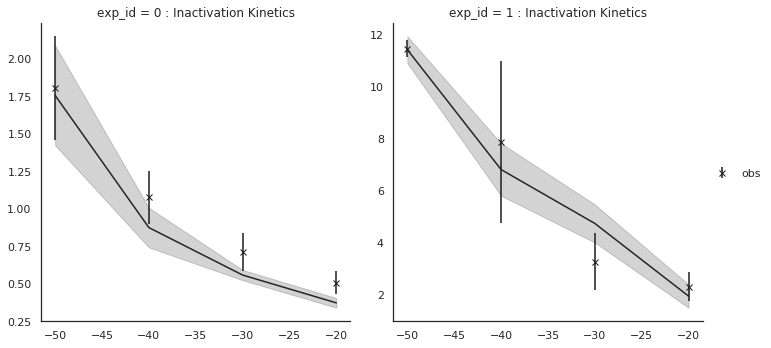

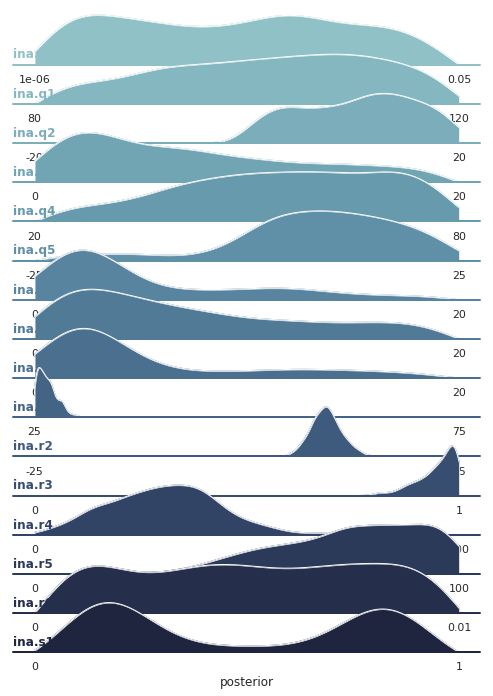

In [16]:
history = History(db_path)
history.id = 56 # (52 corresponds to the availability protocol with HP -80 mV : sakakibara_inact_kin_80)
# (54 corresponds to the availability protocol with HP -80 mV : sakakibara_inact_kin_80 with 30 iterations)
# (55 corresponds to the whole simulation without the recovery and availability experiment)
# (1 on spitfire corresponds to recovery 100)
# (56 corresponds to inactivation kinetics)
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,sakakibara_inact_kin_1,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [17]:
grid1.savefig('results/ina_nygren_experiments_inact_kin_1_saka__pop_10000.pdf')
grid2.savefig('results/ina_nygren_posterior_inact_kin_1_saka_pop_10000.pdf')